# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import math
import pandas as pd
pd.set_option("display.max_columns", 10)

In [2]:
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('/home/abc/Desktop/project/me/Project3//real_estate_data.csv', sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,...,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,...,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,...,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,...,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,...,2.0,112.0,1.0,48.0,121.0


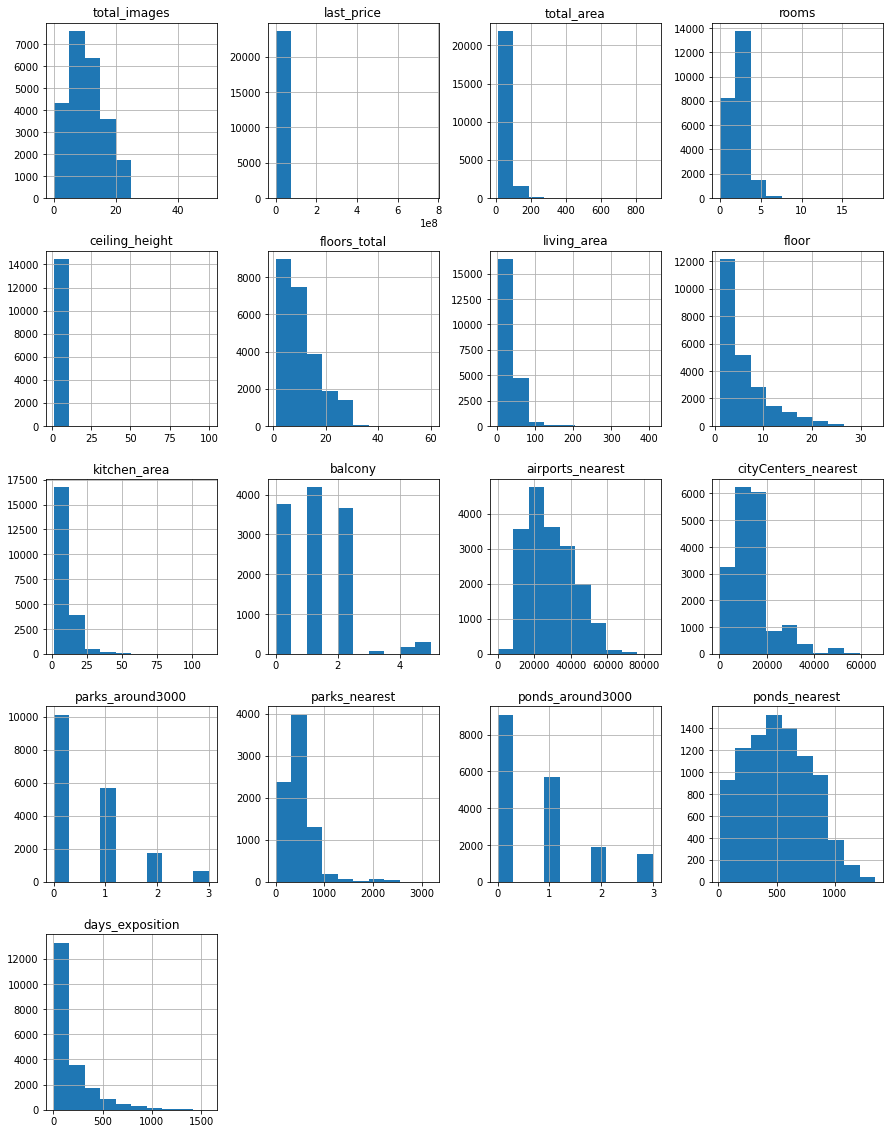

In [3]:
_ = df.hist(figsize=(15, 20))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,...,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,...,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,...,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,...,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,...,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,...,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,...,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**Некорректные названия столбцов:**
* cityCenters_nearest
* parks_around3000
* ponds_around3000

**Пропущенные значения (всего значений < 23699) присутствуют в:**
* ceiling_height
* floors_total
* living_area
* is_apartment
* kitchen_area
* balcony
* locality_name
* airports_nearest
* cityCenters_nearest
* parks_around3000
* parks_nearest
* ponds_around3000
* ponds_nearest
* days_exposition   

Вывод: в данных присутствуют пропуски, не все столбцы приведены к нужному типу; вероятно, присутствуют выбросы. Названия столбцов также не корректны до конца

### Предобработка данных

**Для начала, приведём к нужному виду имена всех столбцов**

In [6]:
df.columns = ['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition']

**Напишем функцию, удаляющую данные, лежащие за 1,5 IQR:**

In [7]:
def iqr_del(column):
    # вычисляем квартили и IQR
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    filt_df = df[(df[column] >= q1 - 2.5 * iqr) & (df[column] <= q3 + 2.5 * iqr)]
    print("Данных вне размаха:", len(df) - len(filt_df))
    return filt_df

**Обработаем пропуски и приведём данные в порядок:**

Total images:

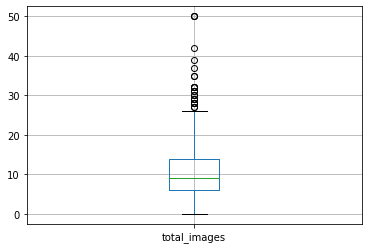

In [8]:
_ = df.boxplot(column='total_images')

In [9]:
df = iqr_del('total_images')

Данных вне размаха: 8


Last price:

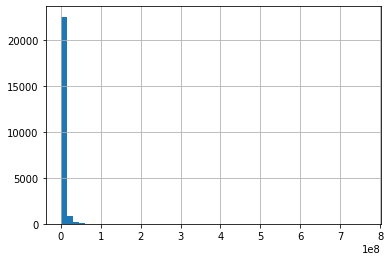

In [10]:
_ = df['last_price'].hist(bins=50)

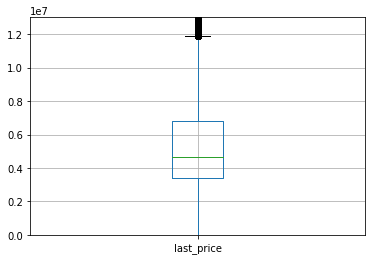

In [11]:
_ = df.boxplot('last_price')
import matplotlib.pyplot as plt
plt.ylim(0, 13_000_000)
plt.show()

In [12]:
df = iqr_del('last_price')

Данных вне размаха: 1187


Total area:

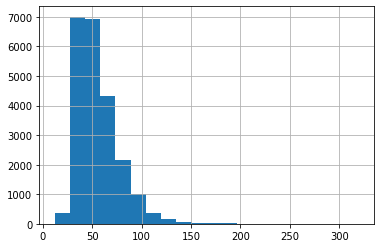

In [13]:
_ = df['total_area'].hist(bins=20)

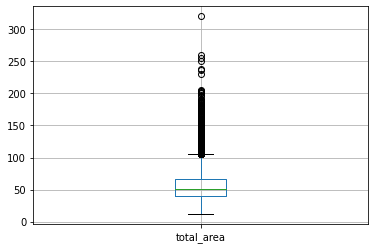

In [14]:
_ = df.boxplot('total_area')

In [15]:
df = iqr_del('total_area')

Данных вне размаха: 175


Floor:

Нет смысла искать выбросы т.к. это просто номер этажа

First day exposition:

In [16]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Тип данных был изменён на целочисленный т.к. число данные в колонке были строкогого типа, а требаволось перейти в тип данных для дат

Rooms:

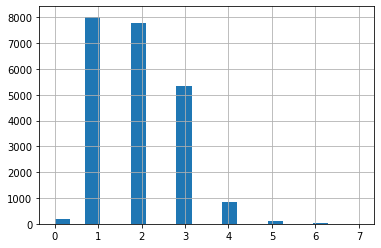

In [17]:
_ = df['rooms'].hist(bins=20)

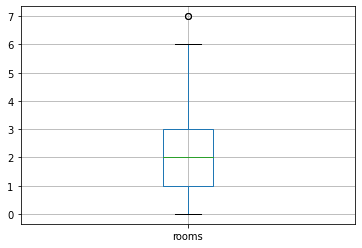

In [18]:
_ = df.boxplot(column='rooms')

In [19]:
df = iqr_del('rooms')

Данных вне размаха: 0


Ceiling height:

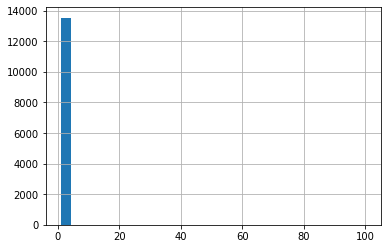

In [20]:
_ = df['ceiling_height'].hist(bins=30)

In [21]:
def right_height(row):
    if row['ceiling_height'] < 2:
        return row['ceiling_height'] * 10
    if row['ceiling_height'] > 14:
        return row['ceiling_height'] / 10
    return row['ceiling_height']
df['ceiling_height'] = df.apply(right_height, axis=1)

In [22]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

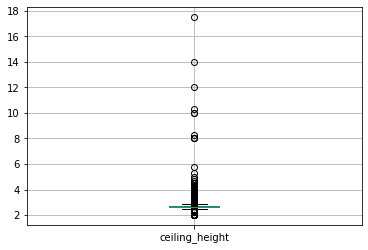

In [23]:
_ = df.boxplot(column='ceiling_height')

In [24]:
df = iqr_del('ceiling_height')

Данных вне размаха: 1963


Total floors:

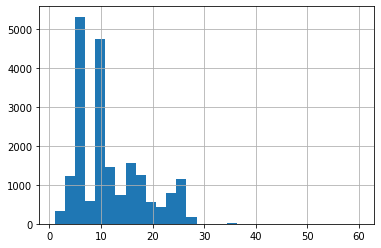

In [25]:
_ = df['floors_total'].hist(bins=30)

In [26]:
df['floors_total'] = df['floors_total'].fillna(1)

In [27]:
df['floors_total'] = df['floors_total'].astype(int)

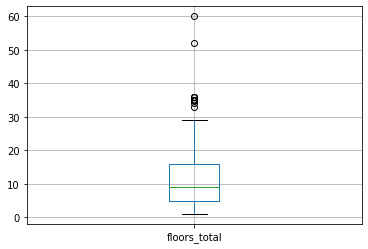

In [28]:
_ = df.boxplot(column='floors_total')

In [29]:
df = iqr_del('floors_total')

Данных вне размаха: 2


Тип данных был изменён на целочисленный т.к. число этажей - дискретно

Living area:

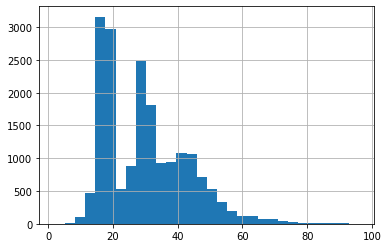

In [30]:
_ = df['living_area'].hist(bins=30)

Для более точного заполнения пропусков попробуем выяснить, влияет количество этажей и наличие балконов на общую площадь:

In [31]:
df['living_area'].corr(df['floors_total'])

-0.12372402353080104

In [32]:
df['living_area'].corr(df['balcony'])

0.0845285591870622

In [33]:
#df['living_area'] = df['living_area'].fillna(df['living_area'].mean())
df['living_area'].isna().sum()

1631

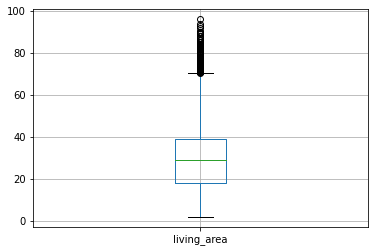

In [34]:
_ = df.boxplot(column='living_area')

In [35]:
df = iqr_del('living_area')

Данных вне размаха: 1635


In [36]:
df['living_area'].isna().sum()

0

Все пропуски оказались за размахом и были удалены

Is apartment:

In [37]:
print(df.loc[df['is_apartment'] == True, 'is_apartment'].count())
print(df.loc[df['is_apartment'] == False, 'is_apartment'].count())
print(df['is_apartment'].isna().sum())

15
2201
16513


Пропусков слишком много и непонятно, что с ними делать; оставим как есть.

Kitchen area:

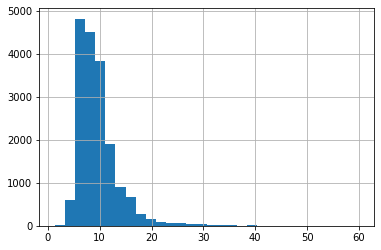

In [38]:
_ = df['kitchen_area'].hist(bins=30)

In [39]:
def correct_area(row):
    if (row['kitchen_area'] >= row['living_area']) \
    or (row['kitchen_area'] / row['living_area'] > 0.9):
        return row['kitchen_area'] / 10
    return row['kitchen_area']
df['kitchen_area'] = df.apply(correct_area, axis=1)

In [40]:
k = (df['kitchen_area'] / df['living_area']).mean()
k

0.34761662641596436

Заполним пропуски отталкисваясь от среднего процентного соотношения площадей кухни и всего помещения:

In [41]:
def my_na_fill(row):
    if math.isnan(row['kitchen_area']):
        return row['living_area'] * k
    return row['kitchen_area']
df['kitchen_area'] = df.apply(my_na_fill, axis=1)

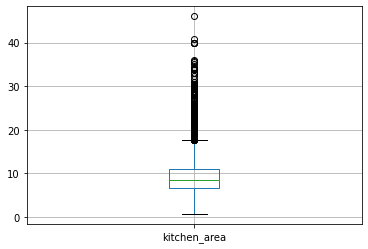

In [42]:
_ = df.boxplot(column='kitchen_area')

In [43]:
df = iqr_del('kitchen_area')

Данных вне размаха: 168


Balcony:

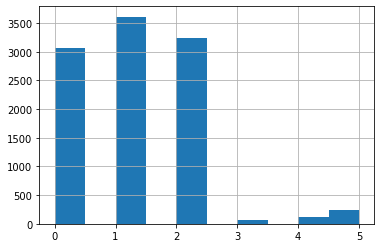

In [44]:
_ = df['balcony'].hist(bins=10)

In [45]:
df['balcony'] = df['balcony'].fillna(0)

In [46]:
df['balcony'] = df['balcony'].astype(int)

Большое число балконов сложно считать выбросами в крупных домах;

Тип данных был изменён на целочисленный т.к. число балконов - дискретно

Nearest airports:

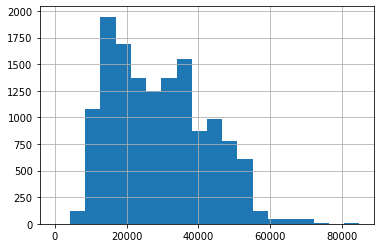

In [47]:
_ = df['airports_nearest'].hist(bins=20)

In [48]:
df['airports_nearest'] = df['airports_nearest'].fillna(df['airports_nearest'].median())

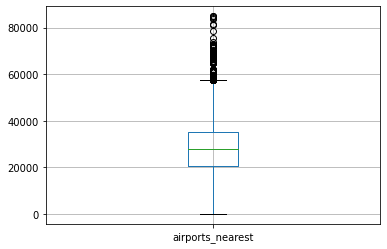

In [49]:
_ = df.boxplot(column='airports_nearest')

In [50]:
df = iqr_del('airports_nearest')

Данных вне размаха: 16


Nearest ciry centers:

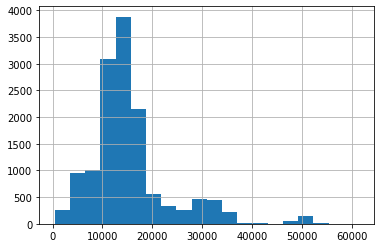

In [51]:
_ = df['city_centers_nearest'].hist(bins=20)

In [52]:
df['city_centers_nearest'] = df['city_centers_nearest'].fillna(df['city_centers_nearest'].median())

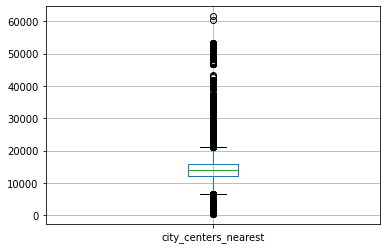

In [53]:
_ = df.boxplot(column='city_centers_nearest')

In [54]:
df = iqr_del('city_centers_nearest')

Данных вне размаха: 1846


Parks and ponds around 3km:

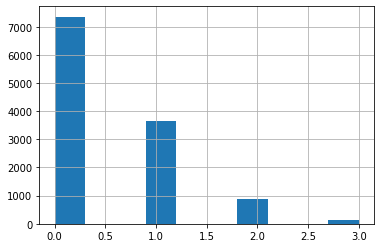

In [55]:
_ = df['parks_around_3000'].hist(bins=10)

In [56]:
df.loc[df['parks_nearest'] <= 3000 \
       & (df['parks_nearest'].isna() | df['parks_nearest'] == 0), \
       ['parks_nearest', 'parks_around_3000']]

,parks_nearest,parks_around_3000


In [57]:
df['parks_around_3000'] = df['parks_around_3000'].fillna(0)

In [58]:
df['parks_around_3000'] = df['parks_around_3000'].astype(int)

Тип данных был изменён на целочисленный т.к. число парков в радиусе 3км - дискретно

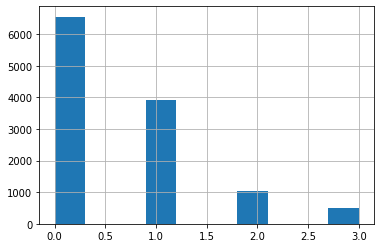

In [59]:
_ = df['ponds_around_3000'].hist(bins=10)

In [60]:
df.loc[df['ponds_nearest'] <= 3000 \
       & (df['ponds_nearest'].isna() | df['ponds_nearest'] == 0), \
       ['ponds_nearest', 'ponds_around_3000']]

,ponds_nearest,ponds_around_3000


In [61]:
df['ponds_around_3000'] = df['ponds_around_3000'].fillna(0)

In [62]:
df['ponds_around_3000'] = df['ponds_around_3000'].astype(int)

Тип данных был изменён на целочисленный т.к. число прудов в радиусе 3км - дискретно

Ponds and Parks nearest:

Пропущенных данных в столбцах ponds_nearest и parks_nearest очень большое количество; вероятно, пользователи просто не заполняли соответствующие графы. Заполним пропуски медианным значением:

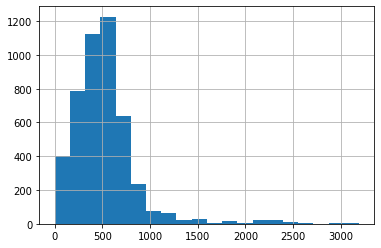

In [63]:
_ = df['parks_nearest'].hist(bins=20)

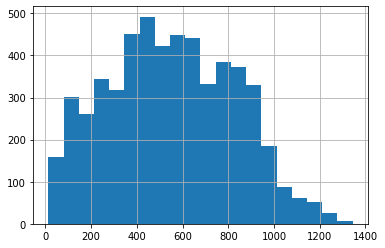

In [64]:
_ = df['ponds_nearest'].hist(bins=20)

In [65]:
df['parks_nearest'] = df['parks_nearest'].fillna(df['parks_nearest'].median())
df['ponds_nearest'] = df['ponds_nearest'].fillna(df['ponds_nearest'].median())

Days exposition:

Вероятно, пропущенные значения - новые объявления; заполним нулями:

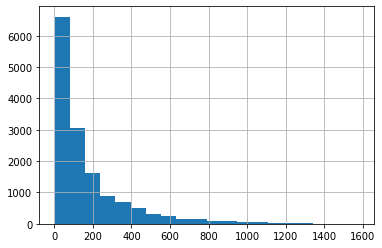

In [66]:
_ = df['days_exposition'].hist(bins=20)

In [67]:
df['days_exposition'] = df['days_exposition'].fillna(0)

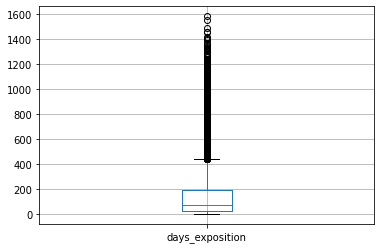

In [68]:
_ = df.boxplot(column='days_exposition')

In [69]:
df = iqr_del('days_exposition')

Данных вне размаха: 746


Природа пропущенных данных во всех столбцах, скорее всего, такова: пользователи сами решили не указывать те или иные данные (число балконов, высота потолков и т.д.)
Также есть вероятность, что произошёл сбой при загрузке данных в систему;

Найдём явные и неявные дубликаты и избавимся от них

In [70]:
df.duplicated().sum()

0

=> Явных дубликатов нет;

In [71]:
df['locality_name'] = df['locality_name'].fillna('')

In [72]:
def splitter(row):
    if row['locality_name']:
        return row['locality_name'].split()[-1]
    return 'unknown'

df['locality_name'] = df.apply(splitter, axis=1)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15953 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          15953 non-null  int64         
 1   last_price            15953 non-null  float64       
 2   total_area            15953 non-null  float64       
 3   first_day_exposition  15953 non-null  datetime64[ns]
 4   rooms                 15953 non-null  int64         
 5   ceiling_height        15953 non-null  float64       
 6   floors_total          15953 non-null  int64         
 7   living_area           15953 non-null  float64       
 8   floor                 15953 non-null  int64         
 9   is_apartment          1855 non-null   object        
 10  studio                15953 non-null  bool          
 11  open_plan             15953 non-null  bool          
 12  kitchen_area          15953 non-null  float64       
 13  balcony         

In [74]:
df['last_price'] = df['last_price'].astype(int)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15953 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          15953 non-null  int64         
 1   last_price            15953 non-null  int64         
 2   total_area            15953 non-null  float64       
 3   first_day_exposition  15953 non-null  datetime64[ns]
 4   rooms                 15953 non-null  int64         
 5   ceiling_height        15953 non-null  float64       
 6   floors_total          15953 non-null  int64         
 7   living_area           15953 non-null  float64       
 8   floor                 15953 non-null  int64         
 9   is_apartment          1855 non-null   object        
 10  studio                15953 non-null  bool          
 11  open_plan             15953 non-null  bool          
 12  kitchen_area          15953 non-null  float64       
 13  balcony         

Вывод: все пропуски заполнены, всё приведено к нужному типу данных; также обработаны выбросы (из большинства столбцов выкинуты значения, лежащие за 2,5 межквартильного размаха); обработаны неявные дубликаты, подправленны некорректные значения

### Посчитаем и добавим в таблицу новые столбцы

In [76]:
df['square_meter_price'] = df['last_price'] / df['total_area']

In [77]:
df['weekday_exposition'] = df['first_day_exposition'].dt.isocalendar().week % 7
df['weekday_exposition']

1        0
2        6
5        2
6        2
8        0
        ..
23691    6
23692    6
23695    3
23696    6
23698    1
Name: weekday_exposition, Length: 15953, dtype: UInt32

In [78]:
df['month_exposition'] = df['first_day_exposition'].dt.month
df['month_exposition']

1        12
2         8
5         9
6        11
8         5
         ..
23691    10
23692     7
23695     1
23696     2
23698     7
Name: month_exposition, Length: 15953, dtype: int64

In [79]:
df['year_exposition'] = df['first_day_exposition'].dt.year
df['year_exposition']

1        2018
2        2015
5        2018
6        2017
8        2018
         ... 
23691    2016
23692    2017
23695    2018
23696    2018
23698    2017
Name: year_exposition, Length: 15953, dtype: int64

In [80]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition', 'square_meter_price',
       'weekday_exposition', 'month_exposition', 'year_exposition'],
      dtype='object')

In [81]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

In [82]:
df['floor_type'] = df.apply(floor_type, axis=1)
df['floor_type']

1        первый
2        другой
5        другой
6        другой
8        другой
          ...  
23691    другой
23692    другой
23695    другой
23696    первый
23698    первый
Name: floor_type, Length: 15953, dtype: object

In [83]:
df['city_centers_nearest_km'] = (df['city_centers_nearest'] / 1000).astype(int)
df['city_centers_nearest_km']

1        18
2        13
5        13
6        19
8        13
         ..
23691     4
23692    13
23695    13
23696    13
23698    13
Name: city_centers_nearest_km, Length: 15953, dtype: int64

### Проведите исследовательский анализ данных

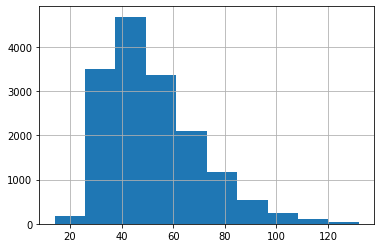

In [84]:
_ = df['total_area'].hist()

In [85]:
print('med:', df['total_area'].median())
df['total_area'].describe()

med: 47.8


count    15953.000000
mean        52.072069
std         18.034133
min         14.000000
25%         38.300000
50%         47.800000
75%         62.000000
max        132.000000
Name: total_area, dtype: float64

Здесь мы видим, что средняя общая площадь ~52кв.м, очень редки квартиры площадью большей 100 и меньшей 20

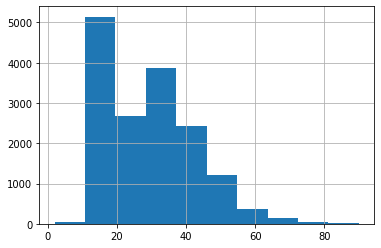

In [86]:
_ = df['living_area'].hist()

In [87]:
print('med:', df['living_area'].median())
df['living_area'].describe()

med: 28.7


count    15953.000000
mean        29.626455
std         12.582585
min          2.000000
25%         18.000000
50%         28.700000
75%         38.000000
max         90.000000
Name: living_area, dtype: float64

средняя жил. площадь ~30кв.м, изредка больше 50 и меньше 10

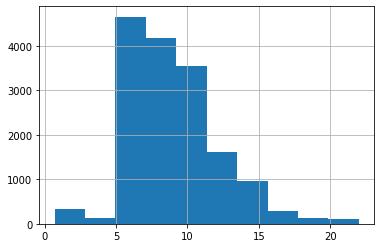

In [88]:
_ = df['kitchen_area'].hist()

In [89]:
print('med:', df['kitchen_area'].median())
df['kitchen_area'].describe()

med: 8.6


count    15953.000000
mean         9.040196
std          3.180038
min          0.695233
25%          6.700000
50%          8.600000
75%         10.900000
max         22.000000
Name: kitchen_area, dtype: float64

Средняя площадь кухни ~9кв.м изредка больше 15 и куда реже меньше 5

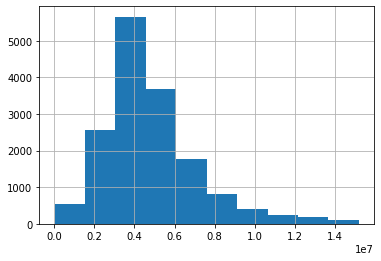

In [90]:
_ = df['last_price'].hist()

In [91]:
print('med:', df['last_price'].median())
df['last_price'].describe()

med: 4350000.0


count    1.595300e+04
mean     4.823980e+06
std      2.371342e+06
min      1.219000e+04
25%      3.300000e+06
50%      4.350000e+06
75%      5.800000e+06
max      1.520000e+07
Name: last_price, dtype: float64

зачастую квартиры продают за ~4_000_000

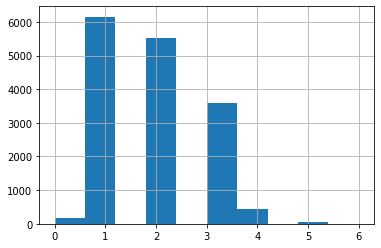

In [92]:
_ = df['rooms'].hist()

In [93]:
print('med:', df['rooms'].median())
df['rooms'].describe()

med: 2.0


count    15953.000000
mean         1.885727
std          0.886864
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

кажется, что в оставшихся данных чаще всего встречаются однокомнатные квартиры

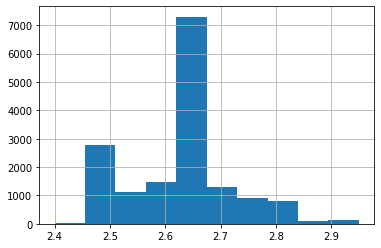

In [94]:
_ = df['ceiling_height'].hist()

In [95]:
print('med:', df['ceiling_height'].median())
df['ceiling_height'].describe()

med: 2.62


count    15953.000000
mean         2.620036
std          0.085756
min          2.400000
25%          2.570000
50%          2.620000
75%          2.620000
max          2.950000
Name: ceiling_height, dtype: float64

Средняя выоста потолков ~262см

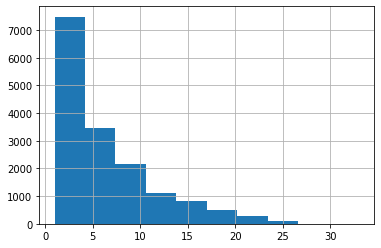

In [96]:
_ = df['floor'].hist()

In [97]:
print('med:', df['floor'].median())
df['floor'].describe()

med: 5.0


count    15953.000000
mean         6.354479
std          5.116009
min          1.000000
25%          3.000000
50%          5.000000
75%          9.000000
max         33.000000
Name: floor, dtype: float64

Кажется, что чаще всего квартиры в объявлениях находятся на этажах меньше пятого

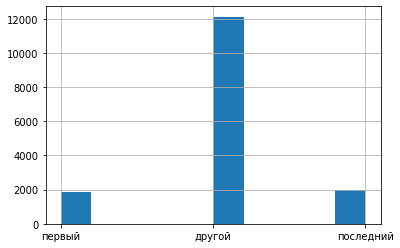

In [98]:
_ = df['floor_type'].hist()

В объявлениях реже указаны крайние этажи

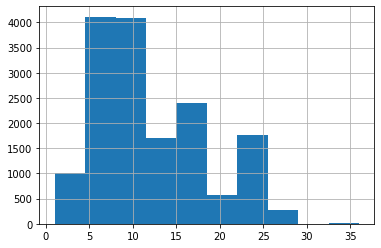

In [99]:
_ = df['floors_total'].hist()

In [100]:
print('med:', df['floors_total'].median())
df['floors_total'].describe()

med: 9.0


count    15953.000000
mean        11.628534
std          6.727253
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         36.000000
Name: floors_total, dtype: float64

В оставшихся объявлениях зачастую продаются квартиры в домах от 5 до 10 этажей

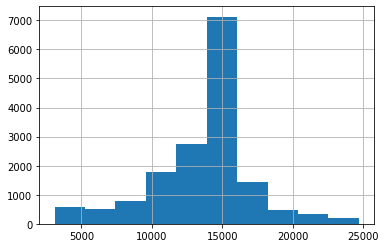

In [101]:
_ = df['city_centers_nearest'].hist()

In [102]:
print('med:', df['city_centers_nearest'].median())
df['city_centers_nearest'].describe()

med: 13906.0


count    15953.000000
mean     13399.372469
std       3465.898061
min       3090.000000
25%      11988.000000
50%      13906.000000
75%      14785.000000
max      24715.000000
Name: city_centers_nearest, dtype: float64

Чаще всего в оставшихся объявлениях расстояние до центра города составляет ~14км

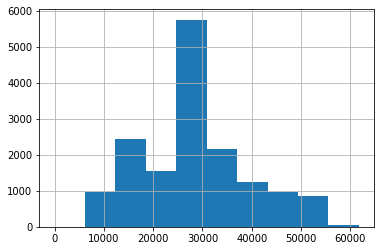

In [103]:
_ = df['airports_nearest'].hist()

In [104]:
print('med:', df['airports_nearest'].median())
df['airports_nearest'].describe()

med: 27850.0


count    15953.000000
mean     28552.547859
std      10898.187221
min          0.000000
25%      20427.000000
50%      27850.000000
75%      34959.000000
max      61748.000000
Name: airports_nearest, dtype: float64

А ближайший аэропорт - в 28км

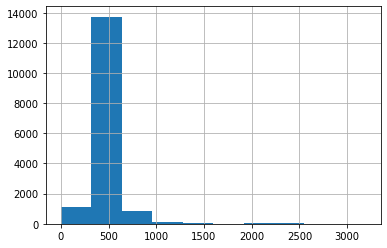

In [105]:
_ = df['parks_nearest'].hist()

In [106]:
print('med:', df['parks_nearest'].median())
df['parks_nearest'].describe()

med: 483.0


count    15953.000000
mean       491.675045
std        177.941794
min          1.000000
25%        483.000000
50%        483.000000
75%        483.000000
max       3190.000000
Name: parks_nearest, dtype: float64

Ближайшие парки зачастую расположены в 500м

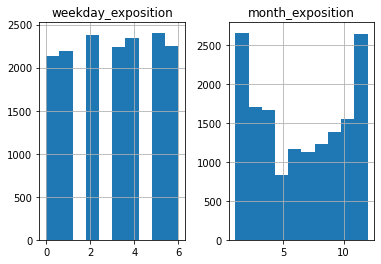

In [107]:
_ = df.hist(column=['weekday_exposition', 'month_exposition'])

In [108]:
print('med:', df['weekday_exposition'].median())
df['weekday_exposition'].describe()

med: 3.0


count    15953.000000
mean         3.043879
std          1.980428
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max          6.000000
Name: weekday_exposition, dtype: float64

Зачастую выставление объявления (хоть они  и были выставлены равномерно по каждому из дней), приходилось на четверг

In [109]:
print('med:', df['month_exposition'].median())
df['month_exposition'].describe()

med: 6.0


count    15953.000000
mean         6.455150
std          3.451957
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64

Наибольшее число объявлений было выставлено в зимние месяца

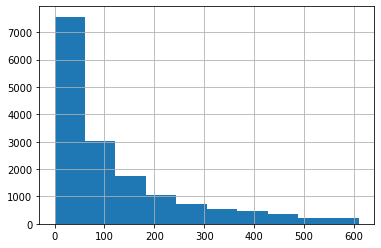

In [110]:
_ = df['days_exposition'].hist()

In [111]:
print('median:', df['days_exposition'].median())
print('mean:', df['days_exposition'].mean())

median: 67.0
mean: 118.51739484736413


Распределение скошенное => медиана более репрезентативна
обычно объявление на сайте висит 62 дня

Продажи, которые занимают менее медианного значения (62), можно считать быстрыми, а продажи, которые занимают более двух медианных значений (124), можно считать необычно долгими. 

In [112]:
df['days_exposition'].describe()

count    15953.000000
mean       118.517395
std        134.845029
min          0.000000
25%         20.000000
50%         67.000000
75%        168.000000
max        610.000000
Name: days_exposition, dtype: float64

In [113]:
168 + 1.5 * (168 - 20)

390.0

In [114]:
20 - 1.5 * (168 - 20)

-202.0

**Влияние факторов**

In [115]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition', 'square_meter_price',
       'weekday_exposition', 'month_exposition', 'year_exposition',
       'floor_type', 'city_centers_nearest_km'],
      dtype='object')

In [116]:
df[['total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type', 'weekday_exposition', 'month_exposition', 'year_exposition', 'last_price']].corr()

,total_area,living_area,kitchen_area,rooms,weekday_exposition,month_exposition,year_exposition,last_price
total_area,1.000000,0.906891,0.488364,0.799405,-0.003860,0.012106,-0.031483,0.712674
living_area,0.906891,1.000000,0.293418,0.893494,-0.000058,0.006458,-0.025149,0.567816
kitchen_area,0.488364,0.293418,1.000000,0.132922,-0.007228,0.015556,-0.024396,0.495411
rooms,0.799405,0.893494,0.132922,1.000000,-0.003641,-0.003015,-0.012581,0.433427
weekday_exposition,-0.003860,-0.000058,-0.007228,-0.003641,1.000000,-0.022866,-0.010798,-0.004873
month_exposition,0.012106,0.006458,0.015556,-0.003015,-0.022866,1.000000,-0.279099,0.002791
year_exposition,-0.031483,-0.025149,-0.024396,-0.012581,-0.010798,-0.279099,1.000000,0.034282
last_price,0.712674,0.567816,0.495411,0.433427,-0.004873,0.002791,0.034282,1.000000


Кажется, что жилплощадь почти прямым образом влияет на цену

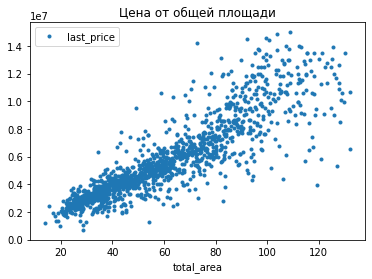

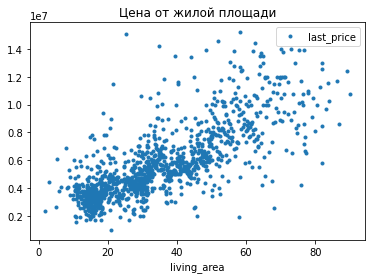

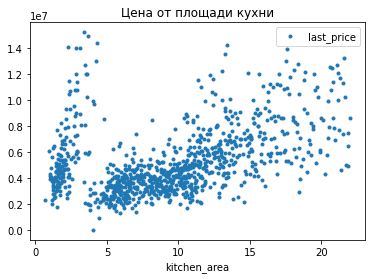

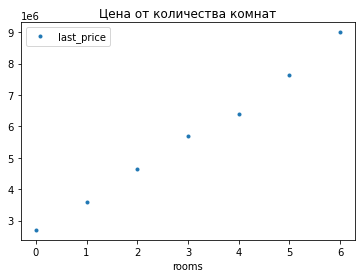

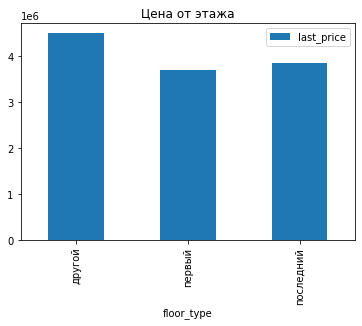

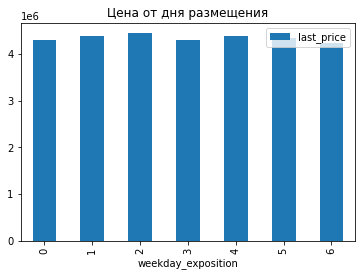

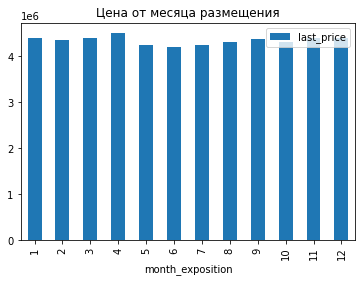

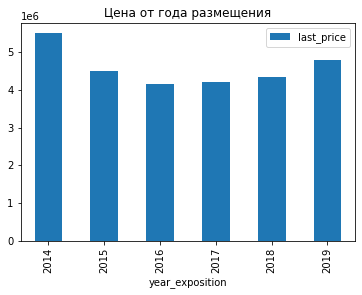

In [117]:
# График зависимости цены от общей площади
df.pivot_table(index='total_area', values='last_price', aggfunc='median').plot(style='.', title='Цена от общей площади')

# График зависимости цены от жилой площади
df.pivot_table(index='living_area', values='last_price', aggfunc='median').plot(style='.', title='Цена от жилой площади')

# График зависимости цены от площади кухни
df.pivot_table(index='kitchen_area', values='last_price', aggfunc='median').plot(style='.', title='Цена от площади кухни')

# График зависимости цены от количества комнат
df.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(style='.', title='Цена от количества комнат')

# График зависимости цены от этажа
df.pivot_table(index='floor_type', values='last_price', aggfunc='median').plot(kind='bar', title='Цена от этажа')

# График зависимости цены от дня размещения
df.pivot_table(index='weekday_exposition', values='last_price', aggfunc='median').plot(kind='bar', title='Цена от дня размещения')

# График зависимости цены от месяца размещения
df.pivot_table(index='month_exposition', values='last_price', aggfunc='median').plot(kind='bar', title='Цена от месяца размещения')

# График зависимости цены от года размещения
_ = df.pivot_table(index='year_exposition', values='last_price', aggfunc='median').plot(kind='bar', title='Цена от года размещения')

Из корреляционной матрицы можно увидеть, что на цену квартиры больше всего влияют ее общая площадь, жилая площадь, площадь кухни и количество комнат.

Графики подтверждают эти выводы: цена квартиры обычно увеличивается с ростом общей площади, жилой площади и количества комнат. Кроме того, цена может зависеть от этажа, на котором расположена квартира. Например, квартиры на первом этаже могут быть дешевле, чем на последнем этаже или на других этажах. Однако, стоит учитывать, что эти зависимости не всегда линейные и могут быть ослаблены другими факторами, такими как местоположение, состояние квартиры и т.д.

In [118]:
df['price_per_sq_m'] = df['last_price'] / df['total_area']

top_localities = df['locality_name'].value_counts().head(10).index.tolist()
data_top_localities = df.query('locality_name in @top_localities')
mean_price_per_sqm = data_top_localities.groupby('locality_name')['price_per_sq_m'].mean()\
                                        .sort_values(ascending=False)

print('Населённый пункт с самой высокой стоимостью за кв.м:', mean_price_per_sqm.index[0])
print('Населённый пункт с самой низкой стоимостью за кв.м:', mean_price_per_sqm.index[-1])

Населённый пункт с самой высокой стоимостью за кв.м: Санкт-Петербург
Населённый пункт с самой низкой стоимостью за кв.м: Выборг


In [119]:
mean_price_per_sqm

locality_name
Санкт-Петербург    105673.717612
Кудрово             96039.656349
Парголово           90226.608757
Мурино              86771.286813
Шушары              81049.023663
Девяткино           77295.201994
Сертолово           69789.530368
Гатчина             68635.246520
Всеволожск          66944.332787
Выборг              57475.249227
Name: price_per_sq_m, dtype: float64

In [120]:
df.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
Санкт-Петербург,10963,4950000.0
Мурино,501,3400000.0
Кудрово,396,3815000.0
Всеволожск,334,3450000.0
Парголово,290,4100000.0
Гатчина,260,3050000.0
Шушары,208,3737500.0
Выборг,157,2750000.0
Сертолово,125,3350000.0


In [121]:
spb_flats = df.query('locality_name == "Санкт-Петербург"') 
spb_flats['price_per_km'] = spb_flats['last_price'] / spb_flats['city_centers_nearest_km']
print('средняя цена за км:', spb_flats['price_per_km'].mean())
#честно, так и не понял, в чём ошибка:(

средняя цена за км: 559564.6499044455


/tmp/ipykernel_78/270885428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spb_flats['price_per_km'] = spb_flats['last_price'] / spb_flats['city_centers_nearest_km']


Обычно цена за квадратный метр выше в тех районах, которые находятся ближе к центру города, и ниже в тех, которые находятся дальше от центра.

Вывод: мы изучили и описали большинство числовых параметров, выявили факторы, больше всего влияющие на общую стоимость квартиры путём построения и последующего анализа графиков посчитали среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [122]:
spb_flats = df.query('locality_name == "Санкт-Петербург"') 
pivot = spb_flats.pivot_table(values='last_price', index='city_centers_nearest_km', aggfunc='mean')
pivot.columns = ['mean_price_per_km']
pivot

,mean_price_per_km
city_centers_nearest_km,
3,7.601018e+06
4,7.984937e+06
5,7.402462e+06
6,7.051717e+06
7,7.137793e+06
8,6.071680e+06
9,5.371002e+06
10,5.351941e+06
11,5.392149e+06


Text(0.5, 1.0, 'Заголовок')

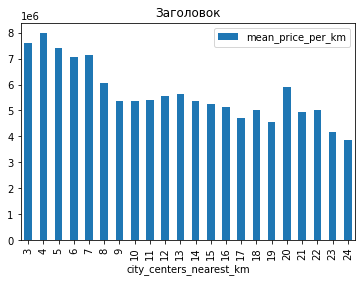

In [123]:
_ = pivot.plot(kind='bar')
plt.title('Заголовок')

## Общий вывод

На основании предварительного анализа данных сервиса Яндекс Недвижимость можно сделать следующие выводы:

* Средняя площадь квартир в Санкт-Петербурге составляет около 52 квадратных метров, при этом большинство квартир имеют площадь от 20 до 100 квадратных метров.

* Цена квартир в Санкт-Петербурге зависит от многих факторов, включая площадь квартиры, количество комнат, удаленность от центра и т.д. Однако, наибольшее влияние на цену оказывает общая площадь, жилая площадь,площадь кухни и количество комнат.

* Средняя цена квадратного метра жилья в Санкт-Петербурге составляет около 106 тысяч рублей, при этом цены на жилье в Санкт-Петербурге значительно выше, чем в соседних населенных пунктах. 